In [1]:
# import warnings
# warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import random
import os
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns',50)

os.chdir('../../../card/')

In [26]:
train = pd.read_csv('train.csv')
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 


test = pd.read_csv('test.csv')
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

submit = pd.read_csv('sample_submission.csv')

In [28]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NAN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NAN,2.0,-47.0,2.0
26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [30]:
train[train.occyp_type=='NAN'].income_type.value_counts()

Pensioner               4440
Working                 2312
Commercial associate    1026
State servant            392
Student                    1
Name: income_type, dtype: int64

In [31]:
train.income_type.value_counts()

Working                 13645
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Name: income_type, dtype: int64

In [37]:
train.occyp_type.value_counts()

NAN                      8171
Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

In [46]:
oc = train[['income_type','occyp_type']].pivot_table(index='income_type',columns='occyp_type',aggfunc='size').fillna(0).T

In [121]:
ocratio =oc/(np.ones((oc.shape))*oc.sum(axis=1).values.reshape(-1,1))*100

In [122]:
ocratio

income_type,Commercial associate,Pensioner,State servant,Student,Working
occyp_type,,,,,
Accountants,40.243902,0.110865,7.649667,0.000000,51.995565
Cleaning staff,19.851117,0.000000,3.970223,0.000000,76.178660
Cooking staff,20.131291,0.000000,8.971554,0.000000,70.897155
Core staff,23.015873,0.075586,24.754346,0.151172,52.003023
Drivers,26.539683,0.063492,5.523810,0.000000,67.873016
HR staff,33.870968,0.000000,4.838710,0.000000,61.290323
High skill tech staff,29.423077,0.000000,14.230769,0.000000,56.346154
IT staff,36.585366,0.000000,14.634146,0.000000,48.780488
Laborers,23.825355,0.066489,3.147163,0.044326,72.916667


In [116]:
oc

income_type,Commercial associate,Pensioner,State servant,Student,Working
occyp_type,,,,,
Accountants,363.0,1.0,69.0,0.0,469.0
Cleaning staff,80.0,0.0,16.0,0.0,307.0
Cooking staff,92.0,0.0,41.0,0.0,324.0
Core staff,609.0,2.0,655.0,4.0,1376.0
Drivers,418.0,1.0,87.0,0.0,1069.0
HR staff,21.0,0.0,3.0,0.0,38.0
High skill tech staff,306.0,0.0,148.0,0.0,586.0
IT staff,15.0,0.0,6.0,0.0,20.0
Laborers,1075.0,3.0,142.0,2.0,3290.0


In [126]:
train[train.income_type =='State servant'].credit.value_counts()

2.0    1400
1.0     489
0.0     265
Name: credit, dtype: int64

In [61]:
ocratio

income_type,Commercial associate,Pensioner,State servant,Student,Working
occyp_type,,,,,
Accountants,5.852951,0.022477,3.203343,0.000000,3.437156
Cleaning staff,1.289906,0.000000,0.742804,0.000000,2.249908
Cooking staff,1.483392,0.000000,1.903435,0.000000,2.374496
Core staff,9.819413,0.044954,30.408542,57.142857,10.084280
Drivers,6.739761,0.022477,4.038997,0.000000,7.834372
HR staff,0.338600,0.000000,0.139276,0.000000,0.278490
High skill tech staff,4.933892,0.000000,6.870938,0.000000,4.294613
IT staff,0.241857,0.000000,0.278552,0.000000,0.146574
Laborers,17.333118,0.067431,6.592386,28.571429,24.111396


In [63]:
train['new_work']  =train['income_type'] +"_"+train['occyp_type']

In [78]:
nw = train[['new_work','credit']].pivot_table(index='new_work',columns='credit',aggfunc='size').fillna(0)

In [93]:
nw.sum(axis=1)

new_work
Commercial associate_Accountants        363.0
Commercial associate_Cleaning staff      80.0
Commercial associate_Cooking staff       92.0
Commercial associate_Core staff         609.0
Commercial associate_Drivers            418.0
                                        ...  
Working_Realty agents                    20.0
Working_Sales staff                    1669.0
Working_Secretaries                      61.0
Working_Security staff                  272.0
Working_Waiters/barmen staff             53.0
Length: 66, dtype: float64

In [91]:
nwratio =(nw/(np.ones((nw.shape))*nw.sum(axis=1).values.reshape(-1,1))*100)

In [107]:
nwtotal = pd.concat([nwratio,nw.sum(axis=1).to_frame().rename(columns={0:'counts'})],axis=1)

In [115]:
nwtotal.loc[nwtotal['counts'] >20].sort_values(2,ascending=False).head(30)

,0.0,1.0,2.0,counts
new_work,,,,
Commercial associate_HR staff,14.285714,0.000000,85.714286,21.0
Working_HR staff,10.526316,10.526316,78.947368,38.0
State servant_Accountants,7.246377,15.942029,76.811594,69.0
State servant_Cooking staff,2.439024,24.390244,73.170732,41.0
Working_Waiters/barmen staff,3.773585,24.528302,71.698113,53.0
Commercial associate_Medicine staff,9.448819,19.685039,70.866142,127.0
Commercial associate_Private service staff,16.666667,12.500000,70.833333,96.0
Working_Security staff,9.558824,20.220588,70.220588,272.0
State servant_Medicine staff,8.759124,21.897810,69.343066,274.0


In [114]:
nwtotal.loc[nwtotal['counts'] >20].sort_values(2).head(30)

,0.0,1.0,2.0,counts
new_work,,,,
State servant_Waiters/barmen staff,0.000000,80.645161,19.354839,31.0
Commercial associate_Waiters/barmen staff,20.000000,30.000000,50.000000,40.0
Commercial associate_Cooking staff,20.652174,27.173913,52.173913,92.0
Working_Secretaries,6.557377,39.344262,54.098361,61.0
Commercial associate_Low-skill Laborers,21.212121,24.242424,54.545455,33.0
State servant_Secretaries,18.181818,27.272727,54.545455,22.0
State servant_Drivers,9.195402,34.482759,56.321839,87.0
Working_Accountants,13.432836,29.211087,57.356077,469.0
Commercial associate_High skill tech staff,13.071895,26.797386,60.130719,306.0


In [19]:
train[train.DAYS_EMPLOYED>=0].income_type.value_counts()

Pensioner    4438
Name: income_type, dtype: int64

In [4]:
def TransDayToDate(df):
    target = df.copy()
    target.loc[target.DAYS_EMPLOYED >0,'DAYS_EMPLOYED'] =0
    target['F_age'] = round(-target.DAYS_BIRTH/ (365.25) +1)
    target['DAYS_EMPLOYED']  =abs(target['DAYS_EMPLOYED'])
    target['begin_month']    =abs(target['begin_month'])
    target['F_DAYS_EMPLOYED_month'] =(target['DAYS_EMPLOYED']/30).astype('int')
    target['F_WorkStartAge']  = target['F_age'] - (target['DAYS_EMPLOYED']/365).astype('int')
    
    
    return target

trainTime =TransDayToDate(train)
testTime =TransDayToDate(test)

drop_col = ['DAYS_BIRTH','FLAG_MOBIL']

try:
    model_train = trainTime.drop(drop_col,axis=1)
    model_test = testTime.drop(drop_col,axis=1)
except:
    pass

from sklearn.ensemble import RandomForestClassifier

def checkUniqueObject(train,test):
    target_col = train.select_dtypes(include= object).columns
    
    check =0
    for col in target_col:
        trainU = train[col].unique()
        testU  = test[col].unique()

        if set(trainU) != set(testU):
            print(col,' have not same Unique values')
            check=1
            
    if check ==0:
        print('all columns have Same Unique values')

checkUniqueObject(train,test)

def LabelEn(train,test):
    trainLa = train.copy()
    testLa  = test.copy()
    
    from sklearn.preprocessing import LabelEncoder
    target_col = train.select_dtypes(include= object).columns
    for col in target_col:
        le = LabelEncoder()
        le.fit(trainLa[col])
        trainLa[col] = le.transform(trainLa[col])
        testLa[col] = le.transform(testLa[col])

    
    return trainLa , testLa

trainLa , testLa = LabelEn(model_train,model_test)

all columns have Same Unique values


In [8]:
train = trainLa
test = testLa

In [9]:
def check_box(x):
    target = train[[x,'credit']]
    sns.boxplot(data=target,x='credit',y=x)
    plt.show()
    display(target.groupby('credit').agg(['mean','std','min','max','size']))
    return

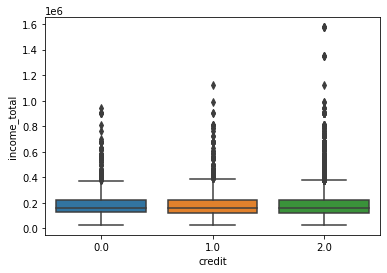

income_total                                          
                 mean            std      min        max   size
credit                                                         
0.0     190807.582402  102139.548208  29250.0   945000.0   3222
1.0     181122.701532   92548.262258  27000.0  1125000.0   6267
2.0     188925.666991  104981.727565  27000.0  1575000.0  16968

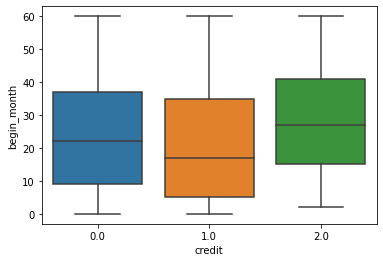

begin_month                             
              mean        std  min   max   size
credit                                         
0.0      23.987896  16.885175  0.0  60.0   3222
1.0      21.078826  17.342548  0.0  60.0   6267
2.0      28.391914  15.715226  2.0  60.0  16968

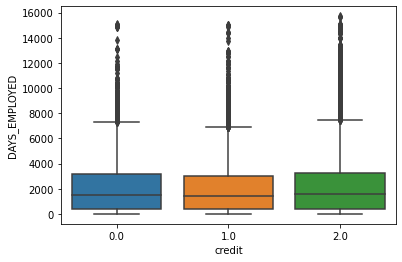

DAYS_EMPLOYED                               
                mean          std min    max   size
credit                                             
0.0      2165.094972  2370.732213   0  15072   3222
1.0      2072.532312  2265.366683   0  15038   6267
2.0      2251.414427  2405.865094   0  15713  16968

In [10]:
target = ['income_total','begin_month','DAYS_EMPLOYED']
for t in target:
    check_box(t)

In [15]:
train[train.DAYS_EMPLOYED ==0].income_type.value_counts()

1    4438
Name: income_type, dtype: int64